# TPC3 - Ensemble Canónico e Teoria Cinética de Gases

• Não deve escrever o seu nome nem nenhum código identificador em nenhum sítio.

• Deve entregar ESTE Notebook de Jupyter.

• O trabalho é individual. Podem e devem haver discussões com colegas mas o resultado entregue é individual.

• Não deve acrescentar ou apagar nenhuma célula

• Todas as explicações devem ser claras e concisas.

• É preferível fazer menos e fazer bem que muito mal.

• O método @jit(nopython=True) do pacote numba pode diminuir o tempo de cálculo.

• A não verificação de alguma destas regras leva ao anulamento e exclusão da prova.

In [ ]:
import numpy as np
from matplotlib.pylab import*
import scipy.linalg as linalg
import numpy.random as rd
import random
from numba import njit
from scipy.optimize import curve_fit

set_printoptions(precision=3, linewidth=200, suppress=True)
%matplotlib inline

# Problema 1 - Termodinâmica de um Gás Perfeito Confinado

Considere um gás clássico de $N\!=\!200$ partículas independentes idênticas com massa $m\!=\!1$ que se movem a uma dimensão, sujeitas a um potencial de confinamento $V\!\!\left(x\right)$. A um dado instante, o microestado do gás pode ser representado como um ponto no espaço de fase $2N$-dimensional - $\mathbf{\mathbf{P}}\!=\!\left(x_{1},p_{1},x_{2},p_{2},\cdots,x_{N},p_{N}\right)$.

1. Escreva uma função que, dado $\mathbf{P}$, calcule a energia mecânica do sistema para qualquer potencial de confinamento.

**Resposta:**

A energia mecânica de ums sistema corresponde à soma das energias cinética e potencial:

$$ E_m = T+U $$

assim, a expressão para a energia mecânica deste sistema de $N$ partículas é dada por:

$$ E_m = \sum_{i=1}^{N}\frac{p_i^2}{2m} +\sum_{j=1}^{N}V(x_j)$$

que pode ser reescirto à custa de $\mathbf{P}$:

$$ E_m = \frac{1}{2m}\sum_{i=1 (\text{ ímpar})}^{N-1}\mathbf{P}[i]^2+\sum_{j=0 \text{ par}}^{N-2}V\left(\mathbf{P}[j]\right) $$

In [ ]:
@njit
def Emec(P,V):
    '''
    P : ponto do espaço de fase 2N-dimensional
    V : potencial de confinamento
    '''
    return .5*sum(P[1::2]**2) + sum(V(P[::2]))

2. Implemente um método de Metropolis (a temperatura $T$) onde em cada proposta, uma das partículas é escolhida aleatoriamente para que o seu estado mecânico seja alterado por um passo aleatório no espaço de fase — i.e. $(x_{i},p_{i})\!\to\!(x_{i}\!+\!\Delta x,p_{i}\!+\!\Delta p)$. [Sugestão: Considere $\Delta x$ e $\Delta p$ como sendo números aleatórios no intervalo $[-2.0,2.0]$. Não se esqueça que cada proposta implica apenas a actualização da energia associada a uma única partícula].

**Resposta:**

Na aplicação do algoritmo de Metropolis, geramos aleatoriamente um número,$n$ entre 0 e 1 e verificamos se este é menor do que valor, segundo a distribuição de Boltzmann (uma vez que estamos perante um gás clássico), para uma dada variação de energia associada a uma única partícula $\Delta E$. Ou seja, a condição de aceitação é

$$ n<e^{-\beta\Delta E} $$

De notar que nesta e em alíneas seguintes teve-se em conta:

$$ \beta = \frac{1}{K_B T} $$

In [ ]:
@njit
def Random_Walk(N,a,b,V,Beta,time):
    '''
    N      : número de partículas do sistema
    a      : limite inferior do potencial de confinamento
    b      : limite superior do potencial de confinamento
    P      : ponto do espaço de fase 2-N dimensional
    V      : potencial de confinamento
    P      : array com as posições e momentos das várias partículas
    Beta   : K_B * T (constante de Boltzmann * Temperatura)
    xs     : array com os índices das partículas às quais
             será feita a proposta de alterar o estado mecâncico
    xi_pi  : array com a posição e momento da partícula escolhida
             aleatoriamente
    xi_pi2 : array com a posição e momento depois do passo aleatorio
             no espaço de fase
    dE     : variação da energia mecânica da partícula
    Emec   : função que calcula a energia mecânica dado uma
             posição e momento
    Energy : array que armazena os valores de energia do
             sistema nos vários instantes
    Esta função retorna um vetor com os valores de energia em cada
    passo da evolução do sistema
    '''
    Energy = zeros(time)
    P = rd.uniform(a,b,2*N)
    xs = [random.randrange(0,2*N,2) for t in range(time)]

    for i in range(len(xs)):
        xi_pi = array([P[xs[i]],P[xs[i]+1]])
        xi_pi2 = xi_pi + (4*rd.random(2)-2)
        n = rd.random()
        dE = Emec(xi_pi2,V)-Emec(xi_pi,V)
        if n < exp(-Beta*dE):
            P[xs[i]],P[xs[i]+1] = xi_pi2
        Energy[i] = Emec(P,V)
    return Energy/N

3. Considere um potencial de confinamento harmónico, $V\left(x\right)=x^{2}/2$. Utilize a rotina de Metropolis escrita na alínea anterior para evoluir o sistema, partindo de um ponto de fase aleatório. Calcule séries temporais (de comprimento $t>2000N$) — $\left\{ \varepsilon_{1},\varepsilon_{2},\cdots\right\}$  — de valores da energia mecânica por partícula, para temperaturas $k_{\text{B}}T\!=\!\left\{ 0.1,1,2,3,4,5,6\right\}$. [Sugestão: Comece de um estado onde $x_{i}$ e $p_{i}$ são números aleatórios uniformemente distribuídos em $[-25,25]$).

**Resposta:**

Para o caso de partícula num gás clássico sujeitas a um potencial harmónico, em equilíbrio térmico, a energia interna do sistema converge para $K_B T$. O que a função Random_Walk definida na alínea anterior está a retornar é precisamente a energia média do sistema em cada instante (já que se divide a energia do sistema - soma das energias de todas as partículas- pelo número de partículas, $N$).

As linhas pretas a traçejado correspodem ao valor de K_B*T


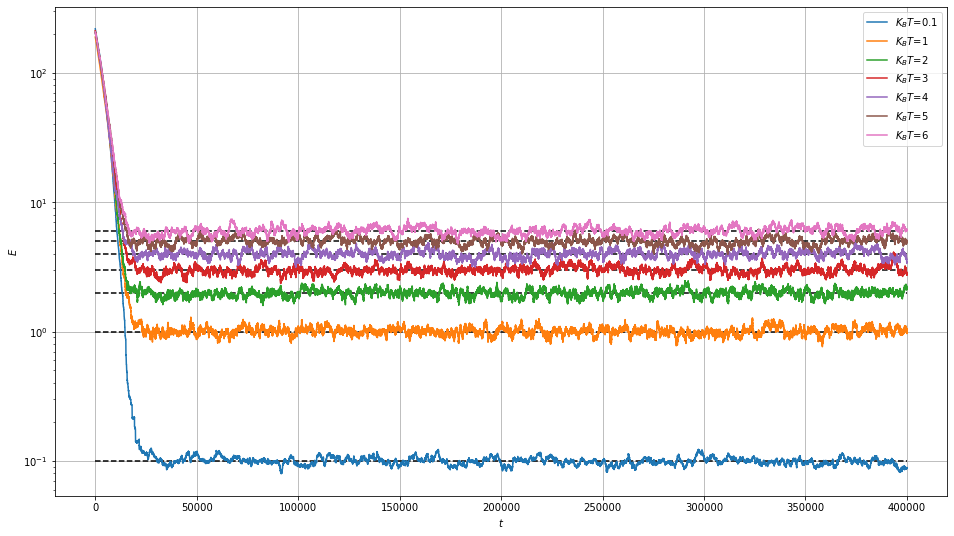

In [ ]:
@njit
def V(x):
    '''
    Define o potencial de confinamento harmónco
    '''
    return .5*x**2

betas = [.1,1,2,3,4,5,6]
N = 200
t = 2000*N

figure(figsize=(16,9))

for beta in betas:
    plot(Random_Walk(N,-25,25,V,1/beta,t),label='$K_{B}T$='+str(beta))
    hlines(beta,xmin=0,xmax = t,color='k',ls='--')
xlabel('$t$')
ylabel('$E$')
yscale('log')
grid()
legend(loc=1);

print('As linhas pretas a traçejado correspodem ao valor de K_B*T')

4. Nos primeiros estágios da evolução estocástica, o sistema ainda “tem memória” do estado de partida. Nestas condições, os estados sucessivos do sistema não amostram correctamente a distribuição de equilibrio — o sistema não está termalizado. A partir das séries temporais obtidas, conclua que o sistema termaliza exponencialmente após algum tempo. Estime esta escala de tempo ($\tau_{\text{th}}$) em unidades do número de passos de Monte Carlo por partícula. Comente a razão para o uso desta unidade de tempo.

**Resposta:**

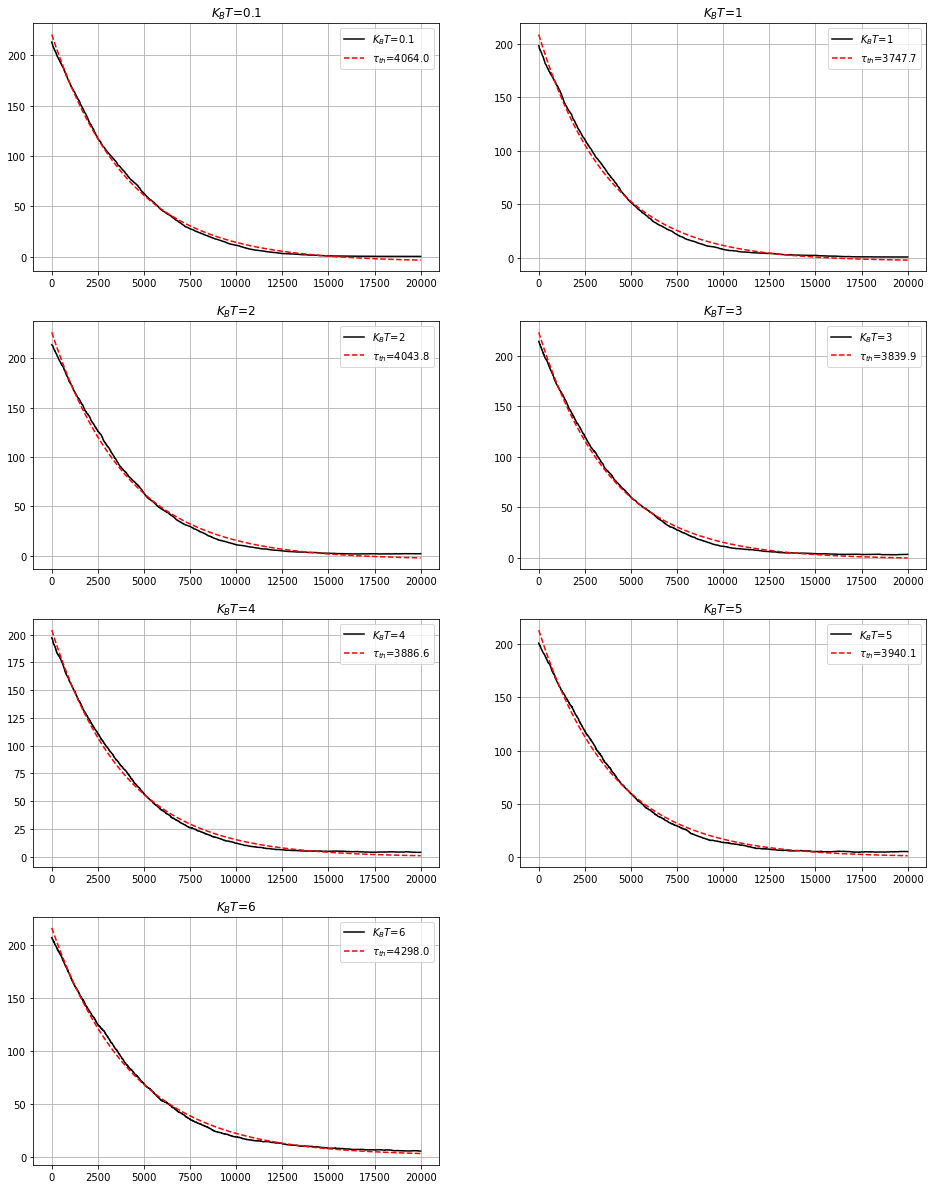

In [ ]:
@njit
def exponencial(t,a,b,tau_th):
    '''
    curva exponencial à qual queremos ajustar os primeiros estágios da evolução
    tau_th : escala de tempo a partir da qual o sistema termaliza
    '''
    return a*exp(-t/tau_th) + b

figure(figsize = (16,21))

for beta in range(len(betas)):
    data = Random_Walk(N,-25,25,V,1/betas[beta],t)[:20000]
    prmtrs,cov = curve_fit(exponencial,arange(0,len(data),1),data)
    subplot(4,2,beta+1)
    title('$K_B T$='+str(betas[beta]))
    plot(data,label='$K_{B}T$='+str(betas[beta]),c='k')
    plot(exponencial(arange(0,len(data),1),prmtrs[0],prmtrs[1],prmtrs[2]),'r--',label='$\\tau_{th}$='+str(round(prmtrs[2],1)))
    legend()
    grid()

5. A dinâmica de Metropolis é um processo de Markov, que gera um sucessão de estados aleatórios para o sistema correlacionados entre si. Calcule o autocorrelador das séries temporais obtidas, i.e.
\begin{equation}
C\left(m\right)\!=\!\frac{\sum_{n}\varepsilon_{n+m}\varepsilon_{n}-\sum_{n}\varepsilon_{n+m}\sum_{l}\varepsilon_{l}}{\sum_{n}\varepsilon_{n}^{2} -\left(\sum_{n}\varepsilon_{n}\right)^{2}}
\end{equation}

e mostre que este decaí exponencialmente com m. Estime a escala de tempo de descorrelação para estas séries temporais ($\tau_{c}$).

**Resposta:**

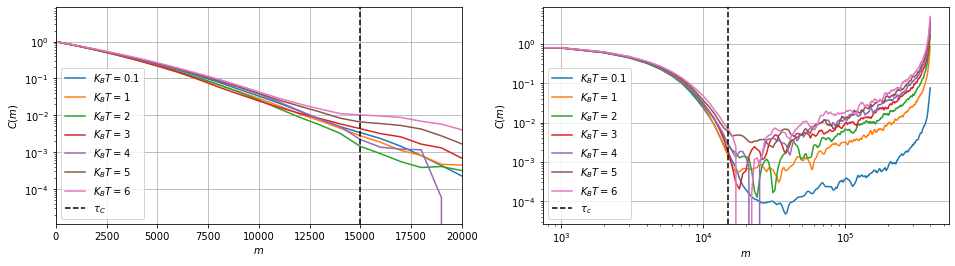

In [ ]:
@njit
def C(m,epsilon):
    '''
    Objetivo : retornar o autocorrelador das séries temporais dado
               pela expressão do enunciado
    epsilon  : vetor com os valores de energia do sistema em cada
               instante da evolução
    m        : parâmetro com o qual C deverá decair exponencialmente
    '''
    size = len(epsilon)
    numerador = mean(epsilon[m:]*epsilon[:size-m]) - mean(epsilon[m:])*mean(epsilon)
    denominador = mean(epsilon**2) - mean(epsilon)**2

    return numerador/denominador

figure(figsize=(16,4))
subplot(121)
for beta in range(len(betas)):
    epsilon1 = Random_Walk(N,-25,25,V,1/betas[beta],t)
    ms = arange(0,len(epsilon1),1000,dtype=int)
    data2 = zeros(len(ms))
    for i in range(len(ms)):
        data2[i] = C(ms[i],epsilon1)
    plot(ms,data2,label = '$K_B T=$'+str(betas[beta]))
axvline(x=15000,c='k',ls='--',label='$\\tau_{C}$')
xlim(0,20000)
# ylim(3e-2)
xlabel('$m$')
ylabel('$C(m)$')
yscale('log')
legend()
grid()

subplot(122)
for beta in range(len(betas)):
    epsilon1 = Random_Walk(N,-25,25,V,1/betas[beta],t)
    ms = arange(0,len(epsilon1),1000,dtype=int)
    data2 = zeros(len(ms))
    for i in range(len(ms)):
        data2[i] = C(ms[i],epsilon1)
    plot(ms,data2,label = '$K_B T=$'+str(betas[beta]))
axvline(x=15000,c='k',ls='--',label = '$\\tau_{c}$')
# ylim(3e-2)
xlabel('$m$')
ylabel('$C(m)$')
yscale('log')
xscale('log')
legend()
grid();

6. Sabendo as escalas $\tau_{\text{th}}$ e $\tau_{c}$ é possivel obter uma amostragem quase descorrelacionada da distribuíção de equilibrio de $\varepsilon$(comente esta afirmação). A partir dessas amostras, estime a energia média $\left\langle\varepsilon\right\rangle$ e a correspondente variância $\sigma_{\varepsilon}^{2}$, como função da temperatura.

**Resposta:**

A energia média pode ser calculada a partir da distribuição de Boltzmann:

$$ \langle\epsilon \rangle = \frac{\sum_{i}\epsilon_i e^{-\beta\epsilon_i}}{\sum_{i} e^{-\beta\epsilon_i}} $$

E variância é obtida da mesma forma:

$$ \sigma_{\epsilon}^2 = \langle\epsilon^2 \rangle-\langle\epsilon \rangle^2 =\frac{\sum_{i}\epsilon_i^2 e^{-\beta\epsilon_i}}{\sum_{i} e^{-\beta\epsilon_i}}-\left(\frac{\sum_{i}\epsilon_i e^{-\beta\epsilon_i}}{\sum_{i} e^{-\beta\epsilon_i}}\right)^2 $$

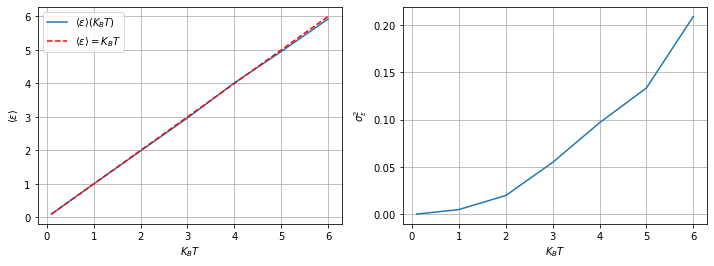

In [ ]:
# vamos criar uma matriz com 7 arrays (vários valores de K_B*T) cada um deles
# com as energias do distema em cada instante da evolução mas só a partir de tau_c, ou seja,
# valores da energia quando o sistema está em equilíbrio
tau_c = 15000
energia_media = zeros(len(betas))
variancia = zeros(len(betas))

for beta in range(len(betas)):
    energias = Random_Walk(N,-25,25,V,1/betas[beta],t)[tau_c:]
    energia_media[beta] = sum(energias*exp(-energias/betas[beta]))/sum(exp(-energias/betas[beta]))
    variancia[beta] =sum((energias**2)*exp(-energias/betas[beta]))/sum(exp(-energias/betas[beta]))-(energia_media[beta])**2

figure(figsize=(12,4))
subplot(121)
plot(array(betas),energia_media,label='$\\langle \\epsilon \\rangle (K_{B}T)$')
plot(array(betas),array(betas),'r--',label='$\\langle \\epsilon \\rangle = K_{B}T$')
xlabel('$K_{B}T$')
ylabel('$\\langle \\epsilon \\rangle$')
grid()
legend()

subplot(122)
plot(array(betas),variancia)
xlabel('$K_{B}T$')
ylabel('$\\sigma_{\\epsilon}^2$')
grid();

7. Determine a energia interna e o calor específico do gás como função da temperatura. Comente os resultados que obteve.

**Resposta:**

In [ ]:
# Escreva o código aqui

8. O confinamento através de um potencial harmónico é o mais simples possível. Considere agora o caso mais geral — $V\!\left(x\right)\!=\!\lambda x^{\alpha}$ — com $\alpha\!=\!4,6$. Derive analiticamente a dependencia da energia interna com a temperatura, nestes dois casos. [Sugestão: Use o formalismo canónico.]

**Resposta:**

In [ ]:
# Escreva o código aqui

9. Simule estes dois casos, usando a rotina anteriormente desenvolvida. Repetindo toda a análise feita para o formalismo canónico, confirme o cálculo anterior, medindo a energia interna do sistema simulado. [Sugestão: Use $\lambda=\frac{1}{2}$]

**Resposta:**

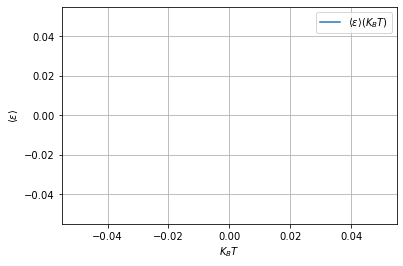

In [ ]:
@njit
def New_Potential(x):
    '''
    x     : vetor com as posições das partículas
    lbd   : parâmetro do potencial de confinamento
    alpha : parâmetro do potencial de confinamento
    '''
    return .5*x**4.6


energia_media2 = zeros(len(betas))

for beta in range(len(betas)):
    energias = Random_Walk(N,-25,25,New_Potential,1/betas[beta],t)
    energia_media2[beta] = sum(energias*exp(-energias/betas[beta]))/sum(exp(-energias/betas[beta]))

plot(array(betas),energia_media2,label='$\\langle \\epsilon \\rangle (K_{B}T)$')
# plot(array(betas),array(betas),'r--',label='$\\langle \\epsilon \\rangle = K_{B}T$')
xlabel('$K_{B}T$')
ylabel('$\\langle \\epsilon \\rangle$')
grid()
legend()

# Problema 2 - Confinamento e Lei dos Gases Perfeitos

Considere um gás de $N$ partículas independentes de massa unitária. Este gás está agora confinado numa “caixa” de comprimento $l$ — i.e. $x_{i}\in[-\frac{l}{2},\frac{l}{2}]$. O potencial associado a esta caixa pode ser modelado do seguinte modo:
\begin{equation}
V_{\text{p}}(x;l)=\begin{cases}
-k\left(\frac{l}{2}+x\right) & \text{se}\, x\leq\frac{l}{2}\\
0 & \text{se} \, -\frac{l}{2}<x<\frac{l}{2}\\
-k\left(\frac{l}{2}-x\right) & \text{se}\, x\geq\frac{l}{2}
\end{cases},
\end{equation}
onde $k\!>\!0$. A força externa correspondente a este potencial é constante, $\pm k$, fora do intervalo da caixa


1. Adapte a rotina de Metropolis do Problema 1 para simular um gás de $N\!=\!200$ partículas sujeito ao potencial $V_{\text{p}}\left(x;l\right)$. Utilize $l\!=\!10$ e $k\!=\!\{0.1,0.5,1.0,5.0\}$.

**Resposta:**

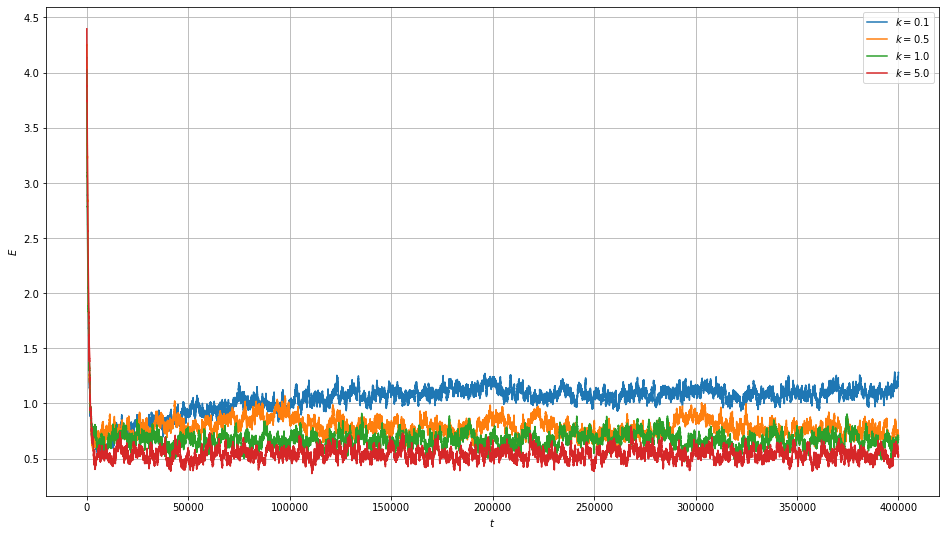

In [ ]:
@njit
def Emec2(P,V,k,l):

    return .5*sum(P[1::2]**2) + sum(V(P[::2],k,l))

@njit
def Vp(x,k,l):
    v = zeros(len(x))
    for i in range(len(x)):
        if x[i]<= -l/2 or x[i]>= l/2:
            v[i] = k*(abs(x[i])-l/2)
        else:
            v[i] = 0
    return v

@njit
def Random_Walk2(N,V,Beta,time,k,l): # adicionou-se a apenas os parâmetros k e l à rotina definida anteriormente

    Energy = zeros(time)
    P = rd.uniform(-l/2,l/2,2*N)
    xs = [random.randrange(0,2*N,2) for t in range(time)]

    for i in range(len(xs)):
        xi_pi = array([P[xs[i]],P[xs[i]+1]])
        xi_pi2 = xi_pi + (4*rd.random(2)-2)
        n = rd.random()
        dE = Emec2(xi_pi2,V,k,l)-Emec2(xi_pi,V,k,l)
        if n < exp(-Beta*dE):
            P[xs[i]],P[xs[i]+1] = xi_pi2
        Energy[i] = Emec2(P,V,k,l)
    return Energy/N

figure(figsize = (16,9))

ks = [0.1,0.5,1.0,5.0]
for k in range(len(ks)):
    passeio = Random_Walk2(200,Vp,1,200*2000,ks[k],10)
    plot(passeio,label = '$k=$'+str(ks[k]))

grid()
legend()
xlabel('$t$')
ylabel('$E$');

2. Calcule uma série temporal do módulo da força externa total aplicada no gás, pela parede da direita, i.e.
$$
\mathcal{F}_{n}\!=\!-k\sum_{i=1}^{N}\Theta(x-\frac{l}{2}),
$$
onde $\Theta(x)$ é a função de Heaviside e $x_{i,n}$ é a posição da partícula i ao passo n da evolução de Metropolis. Faça o cálculo para $k_{\text{B}}T=\text{\{}0.1,0.2,0.3,0.4,0.5\}$ e represente as correspondentes séries temporais. Estime o tempo de termalização destas séries. [Nota: Não precisa de representar os gráficos de todos os valores de $k$. Verifique apenas que não existe grande dependência desta escala em $k$]

**Resposta:**

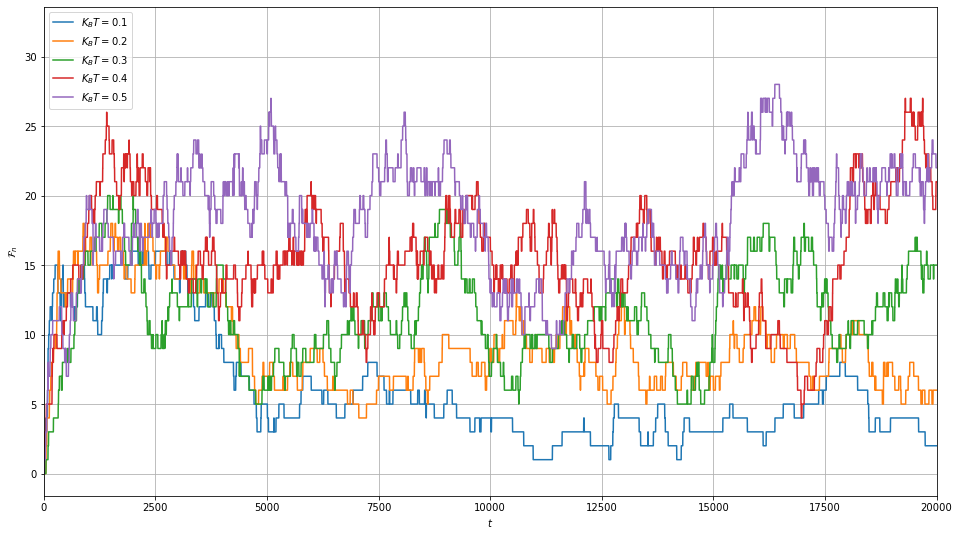

In [ ]:
@njit
def Force_Evolution(N,V,Beta,time,k,l):
    '''
    Force : array onde são armazenados os valores de força
            aplicada no gás depois de cada passo da evolução

    '''
    Force = zeros(time)
    P = rd.uniform(-l/2,l/2,2*N)
    xs = [random.randrange(0,2*N,2) for t in range(time)]

    for i in range(len(xs)):
        xi_pi = array([P[xs[i]],P[xs[i]+1]])
        xi_pi2 = xi_pi + (4*rd.random(2)-2)
        n = rd.random()
        dE = Emec2(xi_pi2,V,k,l)-Emec2(xi_pi,V,k,l)
        if n < exp(-Beta*dE):
            P[xs[i]],P[xs[i]+1] = xi_pi2
        posicoes = P[::2]
        Force[i] = k*len(posicoes[where(np.abs(posicoes)>=l/2)]) #calcula a força (MÓDULO) nos pontos que ficam 'fora' depois da evolução
    return Force

figure(figsize=(16,9))
betas2 = 1/array([.1,.2,.3,.4,.5])
for beta in range(len(betas2)):
    plot(Force_Evolution(200,Vp,betas2[beta],200*2000,1,10),label='$K_B T=$'+str(1/betas2[beta]));
legend()
xlim(0,20000)
grid()
xlabel('$t$')
ylabel('$\\mathcal{F}_n$');

3. Analise a autocorrelação das séries temporais anteriores e determine o tempo de descorrelação correspondente. [Nota: Não precisa de apresentar os resultados para todos os valores de $k$. Verifique apenas que não existe grande dependência em $k$]

**Resposta:**

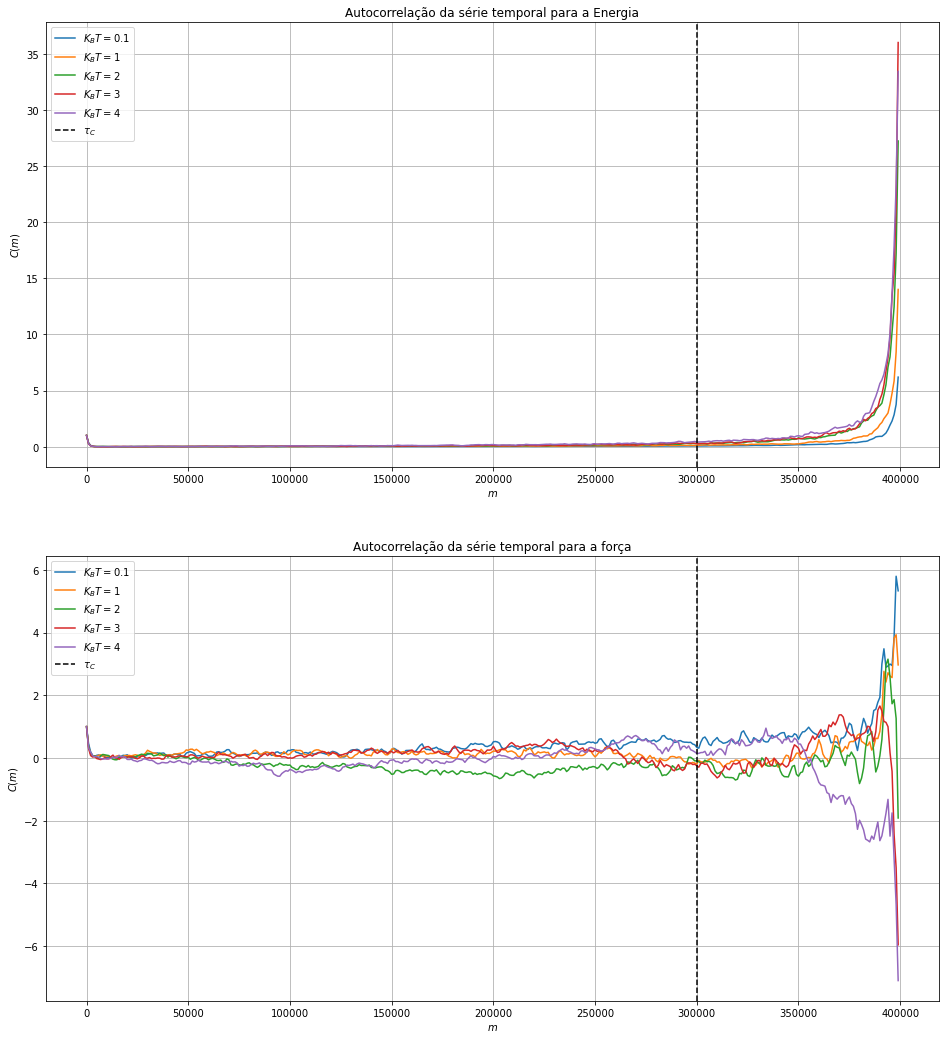

In [ ]:
#------------------------Gráfico de autocorrelação da série temporal para a energia----------------------------------------

figure(figsize = (16,18))
subplot(2,1,1)
title('Autocorrelação da série temporal para a Energia')

for beta in range(len(betas2)):
    epsilon1 = Random_Walk2(200,Vp,betas2[beta],200*2000,1.0,10) # array correspondente à evolução da energia do sistema
    ms = arange(0,len(epsilon1),1000,dtype=int)                  # usando a rotina definida na alínea 1 deste problema
    data2 = zeros(len(ms))
    for i in range(len(ms)):
        data2[i] = C(ms[i],epsilon1)                             # array com os valores de autocorrelador para vários
    plot(ms,data2,label = '$K_B T=$'+str(betas[beta]))           # valores de m. Calculados usando a função definida na
                                                                 # alínea 1.5.
axvline(x=300000,c='k',ls='--',label='$\\tau_{C}$')
xlabel('$m$')
ylabel('$C(m)$')
legend()
grid()

#-------------------------Gráfico de autocorrelação da série temporal para a força-----------------------------------------

subplot(2,1,2)
title('Autocorrelação da série temporal para a força')

for beta in range(len(betas2)):
    epsilon1 = Force_Evolution(200,Vp,betas2[beta],200*2000,1,10) # array correspondente à evolução da força média
    ms = arange(0,len(epsilon1),1000,dtype=int)                   # usando a rotina definida na alínea 2 deste problema
    data2 = zeros(len(ms))
    for i in range(len(ms)):
        data2[i] = C(ms[i],epsilon1)                              # array com os valores de autocorrelador para vários
    plot(ms,data2,label = '$K_B T=$'+str(betas[beta]))            # valores de m. Calculados usando a função definida na
                                                                  # alínea 1.5.
axvline(x=300000,c='k',ls='--',label='$\\tau_{C}$')
xlabel('$m$')
ylabel('$C(m)$')
legend()
grid()

4. Estime a média (no equilíbrio) de $\mathcal{F}_{n}$ como função da temperatura, para os valores de $k$ considerados. Comente o comportamento observado com o aumento de $k$.

**Resposta:**

Tendo a conta a Lei dos Gases Ideais para três dimensões:

$$ pV=nRT $$

podemos obter a relação teórica esperada para o valor médio da força, no caso de um gás de confinado a uma caixa de largura $l$, para o caso a uma dimensão:

$$ \langle\mathcal{F}_{n}\rangle l=NK_{B}T $$

em que $N$ é o número de partículas, que neste caso é 200, e $l=10$. Então, a relação para o valor médio com a temperatura (por simplicidade considerou-se a variação com o produto da temperatura com a constante de Boltzmann) deverá ser:

$$ \langle\mathcal{F}_{n}\rangle=\frac{N}{l}K_B T $$

Fazendo a representação do valor médio da força em função da temperatura (gráficos em baixo), verifica-se que com o aumento do parâmetro $k$ do potencial de confinamento, a lei dos gases ideais deixa de ser verificada.

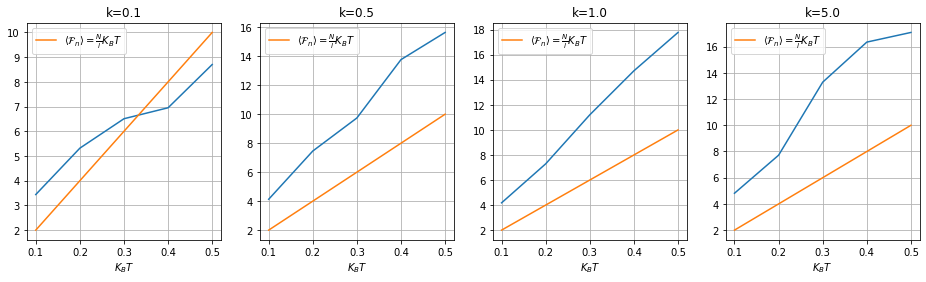

In [ ]:
tau_fc = 50000          # tempo de descorrelação para a média da força
figure(figsize = (16,4))

for k in range(len(ks)):
    subplot(1,4,k+1)
    title('k='+str(ks[k]))
    forca_media = zeros(len(betas2))
    for beta in range(len(betas2)):
        forcas = Force_Evolution(200,Vp,betas2[beta],200*2000,ks[k],10)[:tau_fc]
        forca_media[beta] = mean(forcas)
    plot(1/betas2,forca_media)
    plot(1/betas2,20/betas2,label='$\\langle\\mathcal{F}_{n}\\rangle=\\frac{N}{l}K_B T$')
    xlabel('$K_B T$')
    grid()
    legend();

5. Usando $k\!=\!5.0$, repita a análise para $l=20,40$ e represente os gráficos de $\left\langle \mathcal{F}\right\rangle _{T,l}$, como função de $T$.

**Resposta:**

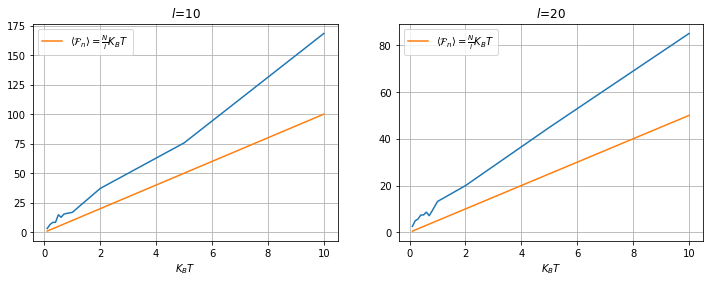

In [ ]:
els = [10,20,40]
betas3 = 1/array([.1,.2,.3,.4,.5,.6,.7,.8,1.0,2.0,5.0,10])
figure(figsize = (12,4))

for l in range(len(els)-1):
    subplot(1,2,l+1)
    title('$l$='+str(els[l]))
    forca_media = zeros(len(betas3))
    for beta in range(len(betas3)):
        forcas = Force_Evolution(200,Vp,betas3[beta],200*2000,5.0,els[l+1])[:tau_fc]
        forca_media[beta] = mean(forcas)
    plot(1/betas3,forca_media)
    plot(1/betas3,(200/els[l+1])/betas3,label='$\\langle\\mathcal{F}_{n}\\rangle=\\frac{N}{l}K_B T$')
    xlabel('$K_B T$')
    grid()
    legend();

6. Colapse as quatro curvas obtidas para $l=10,20,40$ e interprete fisicamente a observável $\left\langle \mathcal{F}\right\rangle _{T,l}$.

**Resposta:**

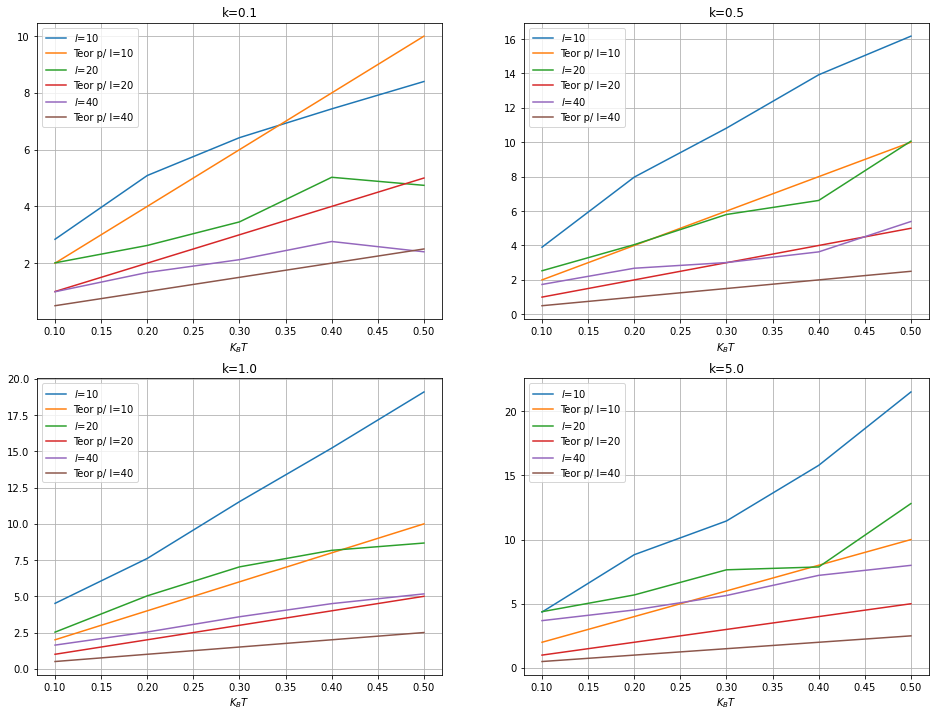

In [ ]:
figure(figsize = (16,12))

for k in range(len(ks)):
    subplot(2,2,k+1)
    title('k='+str(ks[k]))
    for l in range(len(els)):
        forca_media = zeros(len(betas2))
        for beta in range(len(betas2)):
            forcas = Force_Evolution(200,Vp,betas2[beta],200*2000,ks[k],els[l])[:tau_fc]
            forca_media[beta] = mean(forcas)
        plot(1/betas2,forca_media,label='$l$='+str(els[l]))
        plot(1/betas2,(200/els[l])/betas2,label='Teor p/ l='+str(els[l])) # representa a curva teorica para um dado valor de l
    xlabel('$K_B T$')
    legend()
    grid();

# Problema 3 - Gases Interactuantes a Uma Dimensão

Para os alunos que ainda mexem, vamos agora utilizar os métodos de simulação dos exercícios anteriores para estudar um caso mais complicado — um gás clássico monoatómico com interacções interatómicas. Considere-se então um gás de $N$ partículas com massa unitária, confinado numa “caixa” de comprimento $l$, dada por um potencial semelhante ao do Problema 2 (vamos usar $k\!=\!5.0$, de modo a estar já no limite em que a caixa é rigida). Como modelo para o potencial de interacção interatómica vamos tomar
$$
V\left(\{x_{i}\};V_{0},R_{0}\right)=\frac{V_{0}}{2}\sum_{i\neq j}\frac{1}{1+e^{|x_{i}-x_{j}|-R_{0}}},
$$
que é conhecido como o potencial de Woods-Saxon. Para este efeito considere-se $R_{0}\!=\!5$ (correspondente à escala da interacção) e $l\!=\!100$. Para além disso, $V_{0}<0$ para que a interacção seja atractiva, do tipo Van-der-Waals.

1. Adapte o algoritmo de Metropolis do Problema 2 para incluír a interacção entre partículas. O tempo necessário para fazer uma evolução estocástica é agora maior — Porquê?

**Resposta:**

Cada partícula tem agora um potencial adicional resultante da interação com todas as outras partículas. Como tal, na evolução estocástica, para além de ser calculado o potencial intrínseco de cada partícula, é-lhe adicionado este potencial de interação, havendo uma operação adicional em cada interação da série temporal, o que resulta, efetivamente, num aumento do tempo de execução.

In [ ]:
#-------------------------------Função para a energia mecânica com os novos parâmetros R_0 e V_0--------------------------
@njit
def Emec3(P,V,k,l,R0,V0):

    return .5*sum(P[1::2]**2) + sum(V(P[::2],k,l,R0,V0))

#-------------------------------Função para o potencial com os novos parâmetros R_0 e V_0----------------------------------

@njit
def V3(x,k,l,R0,V0):
    '''
    Retorna um array com os valores de potencial (estático + de interação) em cada partícula
    '''
    vest = zeros(len(x))                                 # armazena os valores do potencial estático de cada partícula
    vinter = zeros(len(x))                               # armazena os valores do potencial de interação em cada partícula

    for i in range(len(x)):
        if x[i]<= -l/2 or x[i]>= l/2:                    # cálculo do potencial estático em cada partícula
            vest[i] = k*(abs(x[i])-l/2)
        else:
            vest[i] = 0
    for i in range(len(x)):
        vcont = 0
        for j in range(len(x)):
            if i != j:
                vcont += 1/(1+exp(abs(x[i]-x[j])-R0))    # cálculo do potencial de interação criado por uma partícula i
            else:                                        # na partícula j
                vcont += 0
        vinter[i] = .5*V0*vcont

    return vest + vinter

#---------------------------------Adaptação do algoritmo de Metropolis para o novo potencial------------------------------

@njit
def Random_Walk3(N,V,Beta,time,k,l,R0,V0):

    Energy = zeros(time)
    P = rd.uniform(-l/2,l/2,2*N)
    xs = [random.randrange(0,2*N,2) for t in range(time)]

    for i in range(len(xs)):
        xi_pi = array([P[xs[i]],P[xs[i]+1]])
        xi_pi2 = xi_pi + (4*rd.random(2)-2)
        n = rd.random()
        dE = Emec3(xi_pi2,V,k,l,R0,V0)-Emec3(xi_pi,V,k,l,R0,V0)
        if n < exp(-Beta*dE):
            P[xs[i]],P[xs[i]+1] = xi_pi2
        Energy[i] = Emec3(P,V,k,l,R0,V0)
    return Energy

#---------------------------------Evolução temporal da força definida no ex anterior--------------------------------------

@njit
def Force_Evolution3(N,V,Beta,time,k,l,R0,V0):
    '''
    Force : array onde são armazenados os valores de força
            aplicada no gás depois de cada passo da evolução

    '''
    Force = zeros(time)
    P = rd.uniform(-l/2,l/2,2*N)
    xs = [random.randrange(0,2*N,2) for t in range(time)]

    for i in range(len(xs)):
        xi_pi = array([P[xs[i]],P[xs[i]+1]])
        xi_pi2 = xi_pi + (4*rd.random(2)-2)
        n = rd.random()
        dE = Emec3(xi_pi2,V,k,l,R0,V0)-Emec3(xi_pi,V,k,l,R0,V0)
        if n < exp(-Beta*dE):
            P[xs[i]],P[xs[i]+1] = xi_pi2
        posicoes = P[::2]
        Force[i] = k*len(posicoes[where(np.abs(posicoes)>=l/2)]) #calcula a força (MÓDULO) nos pontos que ficam 'fora' depois da evolução
    return Force

2. Simule séries temporais de energia mecânica e $\mathcal{F}$ [definido no Problema anterior] para $N\!=\!100$ partículas.

**Resposta:**

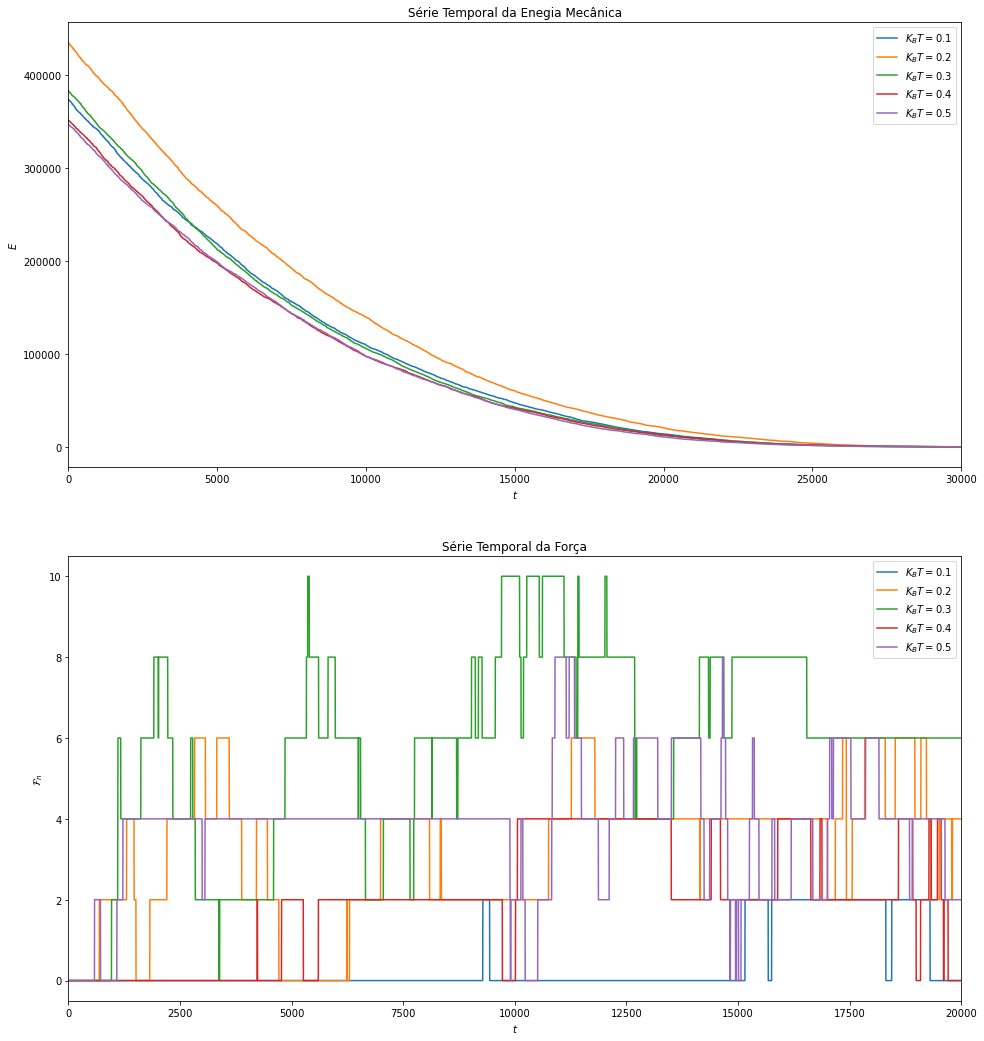

In [ ]:
figure(figsize=(16,18))
betas4 = 1/array([.1,.2,.3,.4,.5])

subplot(211)
title('Série Temporal da Enegia Mecânica')
for beta in range(len(betas4)):
    plot(Random_Walk3(100,V3,betas4[beta],100*1000,2.0,300,5,-0.0001),label = '$K_B T=$'+str(1/betas4[beta]))
ylabel('$E$')
xlabel('$t$')
legend()
xlim(0,30000)

subplot(212)
title('Série Temporal da Força')
for beta in range(len(betas4)):
    plot(Force_Evolution3(100,V3,betas4[beta],100*1000,2.0,300,5,-0.0001),label = '$K_B T=$'+str(1/betas4[beta]))
xlim(0,20000)
ylabel('$\\mathcal{F}_{n}$')
xlabel('$t$')
legend();

3. Estime as escalas de termalização e autocorrelação destas séries temporais.

**Resposta:**

Consideremos o valor de $\beta=1$, ou seja, $K_B T=0.1$. Para determinar a escala de termalização, em semelhança ao que foi feito na alínea 1.4, iremos fazer um ajuste da parte inical das séries temporaia à curva:

$$ f(x) = a\exp{\left(-\frac{t}{\tau_{th}}\right)}+b $$

E vamos também representar graficamente $C(m)$, para vários valores de $K_B T$ à semelhança do que foi feito nas alíneas correspondentes dos problemas 1 e 2. Isto de maneira a identificar o instante, $\tau_c$, a partir do qual as energias mecânicas das partículas deixam de estar correlacionadas, ou seja, o instante a partir do qual entramos em equilíbrio.

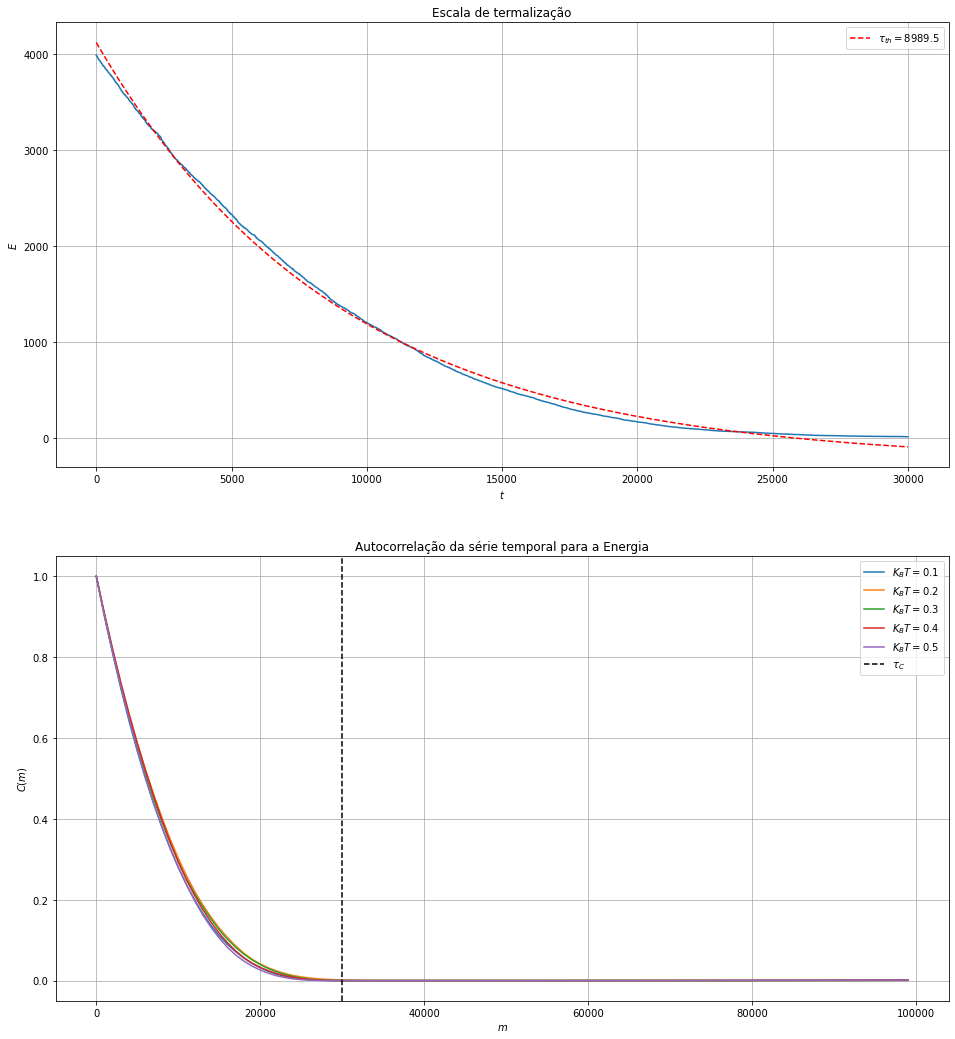

In [ ]:
def exponencial3(t,a,b,tau_th):
    return a*exp(-t/tau_th) + b

tempo = arange(0,len(serie_energia),1)
serie_energia = Random_Walk3(100,V3,0.1,100*1000,2.0,300,5,-0.0001)[:30000]
pt,covar = curve_fit(exponencial3,tempo,serie_energia)

figure(figsize = (16,18))
subplot(211)
title('Escala de termalização')
plot(serie_energia)
plot(tempo,exponencial3(tempo,pt[0],pt[1],pt[2]),'r--',label='$\\tau_{th}=$'+str(round(pt[2],1)))
legend()
grid()
xlabel('$t$')
ylabel('$E$')

subplot(212)
title('Autocorrelação da série temporal para a Energia')

for beta in range(len(betas4)):
    epsilon1 = Random_Walk3(100,V3,betas4[beta],100*1000,2.0,300,5,-0.0001) # array correspondente à evolução da energia do sistema
    ms = arange(0,len(epsilon1),1000,dtype=int)                  # usando a rotina definida na alínea 1 deste problema
    data2 = zeros(len(ms))
    for i in range(len(ms)):
        data2[i] = C(ms[i],epsilon1)                             # array com os valores de autocorrelador para vários
    plot(ms,data2,label = '$K_B T=$'+str(1/betas4[beta]))


axvline(x=30000,c='k',ls='--',label='$\\tau_{C}$')
xlabel('$m$')
ylabel('$C(m)$')
legend()
grid()

4. Usando uma série descorrelacionada de energias mecânicas, determine a energia interna como função da temperatura para diferentes valores de $V_{0}$. [Sugestão: Use $V_{0}=-0.1,0.5,1.0$]

**Resposta:**

Tendo agora o valor de escala de autocorrelação da energia mecânica, podemos estudar a energia interna do sistema, que corresponde à soma da energia mecânica de todas as partículas, no equilíbrio, ou seja, a partir do intante em que as energias das partículas deixam de estar correlacionadas. No entanto, calcular a soma das energias cinéticas de todas as partículas é precisamente o que as funções que calculam a energia mecânica, definidas neste exercício e em anteriores para um dado vetor $P$ fazem.

Posto isto, podemos tomar uma série descorrelacionada de energias mecânicas do sistema a e fazer a sua média. E este valor corresponderá precisamente à energia interna do sistema para a temperatura em estudo.

Por indicação dos docentes os valore de $V_0$ a ser usados serão no intervalo [-0.001,-0.0001] e os valores de tempertura na ordem de $K_B T=1$

Verifica-se que $E = NK_B T$


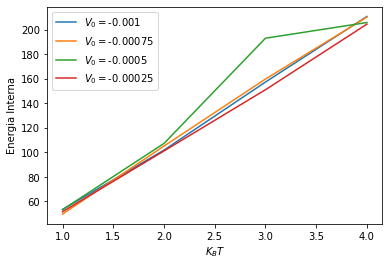

In [ ]:
V0s = arange(-0.001,-0.0001,.00025)
kbts = [1,2,3,4]

for v0 in range(len(V0s)):
    energies = zeros(len(kbts))
    for kbt in range(len(kbts)):
        energies[kbt] = np.mean(Random_Walk3(100,V3,1/kbts[kbt],100*1000,2.0,300,5,V0s[v0])[30000:])
    plot(array(kbts),energies,label='$V_0 =$'+str(V0s[v0]))
xlabel('$K_B T$')
ylabel('Energia Interna')
legend();


5. Usando a série $\mathcal{F}_{n}$, determine a pressão como função da temperatura, para os mesmos valores de $V_{0}$. Comente as diferenças relativamente ao Problema 2.

**Resposta:**

Pela Lei dos Gases ideais:

$$ PV=NK_B T \\ \frac{\mathcal{F}_n}{A}Al=NK_B T \\ \mathcal{F}_n =\frac{N}{l}K_B T $$

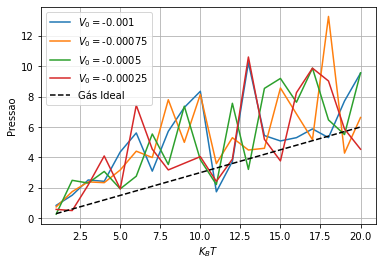

In [ ]:
kbts1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for v0 in range(len(V0s)):
    energies = zeros(len(kbts1))
    for kbt in range(len(kbts1)):
        energies[kbt] = np.mean(Force_Evolution3(100,V3,1/kbts1[kbt],100*1000,2.0,300,5,V0s[v0])[30000:])
    plot(array(kbts1),energies,label='$V_0 =$'+str(V0s[v0]))
plot(array(kbts1),.3*array(kbts1),'k--',label='Gás Ideal') # coloca-se o prefator N/l
xlabel('$K_B T$')
ylabel('Pressao')
legend()
grid();

6. Escolha um $V_{0}$ onde haja diferenças relativamente ao caso não interactuante e repita o estudo para $l=100,200,400$. Ainda verifica a lei dos gases perfeitos?

**Resposta:**

Usou-se o valor de $V_0 = -0.0001$.

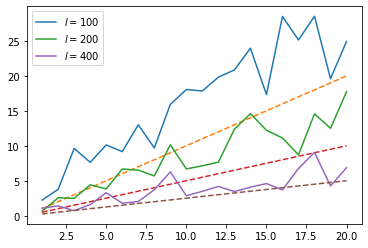

In [ ]:
els = [100,200,400]
for l in range(len(els)):
    pressoes = zeros(len(kbts1))
    for kbt in range(len(kbts1)):
        pressoes[kbt] = np.mean(Force_Evolution3(100,V3,1/kbts1[kbt],100*1000,2.0,els[l],5,-.0001)[30000:])
    plot(array(kbts1),pressoes,label='$l=$'+str(els[l]))
    plot(array(kbts1),(100/els[l])*array(kbts1),ls='--') # coloca-se o prefator N/l
legend();

Boa Sorte!